<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/airline2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Embeddings

_Basic assumption: airlines fliying similar routes are similar_

## Data Sets
* Single Flights: http://stat-computing.org/dataexpo/2009/the-data.html
* Routes between airports: https://openflights.org/data.html#route


In [1]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  1768k      0  0:00:01  0:00:01 --:--:-- 1768k


In [0]:
# pd.read_csv?

In [3]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)
len(df)

67663

In [4]:
df.head()

,Airline,Source airport,Destination airport
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB


In [5]:
sources = df['Source airport'].unique()
len(sources)

3409

In [6]:
destinations = df['Destination airport'].unique()
len(destinations)

3418

In [7]:
airlines = df['Airline'].unique()
len(airlines)

568

In [8]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.0-rc1


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

import numpy as np

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)
encoded_airlines

array([241, 241, 241, ..., 543, 543, 543])

In [10]:
len(encoded_airlines) 

67663

In [11]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)
routes.head()

0    AER KZN
1    ASF KZN
2    ASF MRV
3    CEK KZN
4    CEK OVB
dtype: object

In [0]:
routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [13]:
# should be a bit more 3400 as source and destination are from the same set
output_dim = len(routes_tokenizer.word_index)
output_dim

3425

In [14]:
encoded_routes[0]

array([511, 491])

In [15]:
len(encoded_routes)

67663

In [0]:
# sequence of airlines encoded as a unique number
x = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = encoded_routes

## 2d embeddings

In [31]:
%%time

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

input_dim = len(airlines)
embedding_dim = 2

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(GlobalAveragePooling1D())
# model.add(Flatten())

model.add(Dense(units=50, activation='relu'))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Dense(units=output_dim, name='output', activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              1136      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3425)           174675    
Total params: 181,011
Trainable params: 181,011
Non-trainable params: 0
_________________________________________________________________
CPU 

In [32]:
model.predict(np.array([x[0]])).shape

(1, 2, 3425)

In [33]:
Y.shape

(67663, 2)

In [0]:
%%time

EPOCHS=5
BATCH_SIZE=1000

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)


plt.yscale('log')
plt.plot(history.history['loss'])

In [35]:
# loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
# loss, accuracy
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

RuntimeError: ignored

In [36]:
samples = pd.DataFrame(encoded_airlines).sample(n=100).values.reshape(-1)
samples

array([ 73,   7,  78,   3, 210,   3,   3,  12,  53, 144,   6,   5,   6,
        91, 207, 160, 104,  65, 226,   1, 357, 146,   4, 116, 187,  13,
         1,  22, 201,  10,   4,  24,   2,  24,  27,   5,  13,   2,  22,
        31,  17,  33, 223,  20, 457,  41,   5,  31,  37,  27, 402, 100,
         2,   7,   3,  61,  69,  26,   1,  27,   3,  74, 106,   9,   1,
        86, 103,   6, 295,  21, 119, 213, 273,  20, 146, 175,  11,  44,
        63,  27, 303,  77,  44,  82,   2,  26,  91,  99,   8,   9, 223,
       101, 434, 539, 284,  30,  13,  61,   8,   1])

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(samples).reshape(-1, 2)
embeddings_2d

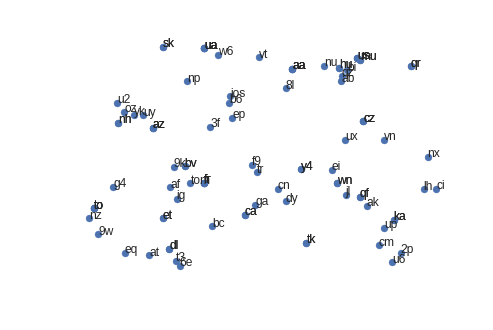

In [40]:

# for printing only
# plt.figure(dpi=600)
plt.axis('off')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for index, x_pos, y_pos in zip(samples, embeddings_2d[:, 0], embeddings_2d[:, 1]):
  name = airline_tokenizer.index_word[index]
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos))